<H1>Passing Yards Furnished
<H2> Author: Gabriel Fairbrother

I am proposing a simple to understand metric where we credit blocking players for a percentage of the earned yardage in a play (or any larger slice of time desired) based on how long they hold their blocks. Using the current data it was simplist to use the PFF blocking assignments, and they bear out fairly well. This could be adapted to be more particular. I believe the metric could also be adapted to punish missed blocks or give more credit to certain kinds of blocks (like chip blocks or pancake blocks).

I think that as you aggregate Passing Yards Furnished out it will start to identify the most standout offensive linemen (and indeed blocking Tight Ends or blocking receivers, an under-identified quality of good players at these positions).

In [242]:
import pandas as pd
import numpy as np
import os
import matplotlib
import seaborn as sns
# import seaborn.objects as so

from  scipy.spatial.distance import euclidean
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

path = 'data/'
max_block_distance = 1.5 # This was an arbitrary choice for how close a blocker is to their assignment based on my estimation and can be edited

plays = pd.read_csv(path + 'plays.csv')
pff = pd.read_csv(path + 'pffScoutingData.csv')
players = pd.read_csv(path + 'players.csv')

In [215]:


# Filter completed pass plays
completed_pass_plays = plays.loc[plays['passResult']=='C']

# Dropping all negative penalty plays for simplicity
completed_pass_plays = completed_pass_plays.drop(completed_pass_plays.index[completed_pass_plays['penaltyYards'] < 0])

# Drop extra columns and prep index for join
completed_pass_plays = completed_pass_plays[['gameId', 'playId', 'playResult']]
completed_pass_plays.set_index(['gameId', 'playId'], inplace=True)


In [216]:
#Filter Pass Blockers and create frame of pass blockers on each completed play
pff_blockers = pff.loc[pff['pff_role']=='Pass Block']
pff_blockers.set_index(['gameId', 'playId'], inplace=True)

completed_pass_blockers = completed_pass_plays.join(pff_blockers)
completed_pass_blockers.reset_index( inplace=True)
completed_pass_blockers.set_index(['gameId', 'playId', 'nflId'], inplace=True, append=False)

In [217]:
# Process tracking data csv
processed_tracking = pd.DataFrame()
for filename in os.listdir(path):
    if filename.startswith('week'):
        
        tracking_data = pd.read_csv(path + filename)
        processed_tracking = pd.concat([processed_tracking, tracking_data])

#Set multilevel index
processed_tracking.set_index(['gameId', 'playId', 'nflId'], inplace=True, append=False)

In [218]:
# Create pass blocker tracking table
pass_completed_tracking = completed_pass_blockers.join(processed_tracking, how='inner')



In [219]:
#Capture snap frame for each play
frame_snap = pass_completed_tracking.reset_index()
frame_snap = frame_snap.loc[frame_snap['event'] == 'ball_snap'][['gameId','playId','frameId']].drop_duplicates()
frame_snap = frame_snap.rename(columns= {'frameId':'snap'})

# Capture pass frame for each play
frame_pass = pass_completed_tracking.reset_index()
frame_pass = frame_pass.loc[frame_pass['event'] == 'pass_forward'][['gameId','playId','frameId']].drop_duplicates()
frame_pass = frame_pass.rename(columns= {'frameId':'pass'})

# Create frame lookup table
for table in [frame_snap, frame_pass]:
    table.set_index(['gameId', 'playId'], inplace=True)

frame_window = frame_snap.join(frame_pass, on=['gameId', 'playId'], how='inner')


In [220]:
# Create a list of players blocking and blocked on each play
blocking_list = []
for game, blocker in pass_completed_tracking.groupby(level=[0, 1, 2]):
    blockeridx = list(blocker.index[0])
    blockeridx.append(blocker.pff_nflIdBlockedPlayer.unique()[0])
    blocking_list.append(blockeridx)
  

In [221]:
# Calculate the distance between blocker and blocked in every frame, then sum all frames within 'max blocking distance' defined in cell 1

score_keeping = {}
for block in blocking_list:
    if not (np.isnan(block).any()):
        # Create entries if absent
        if not block[0] in score_keeping:
            score_keeping[block[0]] = {}
        if not block[1] in score_keeping[block[0]]:
            score_keeping[block[0]][block[1]] = {}
       
        try: 

            snap = frame_window.loc[block[0], block[1]]['snap'].item()
            fwd_pass = frame_window.loc[block[0], block[1]]['pass'].item()

            blocker_data = processed_tracking.loc[block[0], block[1], block[2]].query('@snap < frameId < @fwd_pass')[['x', 'y']]
            blocked_data = processed_tracking.loc[block[0], block[1], block[3]].query('@snap < frameId < @fwd_pass')[['x', 'y']]
            blocker_data.apply(pd.to_numeric)
            blocked_data.apply(pd.to_numeric)

            distance = []
            for i in range(fwd_pass-snap-1):
                
                distance.append(euclidean(blocker_data.iloc[i], blocked_data.iloc[i])) # I originally used math.dist() here which was faster but its not available on kaggle

            result = sum(i < max_block_distance for i in distance)
            score_keeping[block[0]][block[1]][block[2]] = result

        # There are some malformed entries due to anomalies in the data that could be scrubbed in a proper pipeline but are easier to skip here
        except KeyError: 
            continue
        except ValueError:
            continue


In [222]:
# Calculate the percentage of the total "block held time" for each blocker. this total is the aggregate time of all blocks held during the play from the snap to the forward pass
for game, plays in score_keeping.items():
    for play, blockers in plays.items():
        total = 0
        for blocker, score in blockers.items():
            total += score
        blockers['block_total'] = total
        for blocker, score in blockers.items():
            if blocker == 'block_total':
                continue
            if total == 0:
                blockers[blocker] = 0
            else: 
                blockers[blocker] = score/total

In [223]:
# Calculate the Passing Yards Furnished per play
for game, plays in score_keeping.items():
    for play, blockers in plays.items():
        yards = completed_pass_plays.loc[game, play].item()
        
        for blocker, score in blockers.items():
            if blocker == 'block_total':
                continue
            blockers[blocker] = blockers[blocker] * yards
            

In [224]:
# Lets simplify the dictionary by game per player
passing_yards_furnished = {}
for game, plays in score_keeping.items():
    passing_yards_furnished[game] = {}
    for play, blockers in plays.items():
        for blocker, score in blockers.items():
            if blocker == 'block_total':
                continue
            if not blocker in passing_yards_furnished[game]:
                passing_yards_furnished[game][blocker] = 0
            passing_yards_furnished[game][blocker] += score


In [225]:
# Here is the metric per player for a chosen game. Note that it is both teams
target_game = 2021090900
disp_players = players[['nflId', 'officialPosition', 'displayName']]
disp_players.set_index('nflId', inplace=True, append=False)
display_table = disp_players.join(pd.DataFrame.from_dict(passing_yards_furnished[target_game], orient='index', columns=['Passing_Yards_Furnished']), how = 'inner')


In [226]:
display_table.sort_values('Passing_Yards_Furnished', ascending=False)

,officialPosition,displayName,Passing_Yards_Furnished
42404,G,Ali Marpet,92.986370
46163,G,Alex Cappa,92.785468
46119,G,Connor Williams,68.559486
47873,G,Connor McGovern,62.405246
52421,T,Tristan Wirfs,62.170969
42654,T,La'el Collins,59.060823
52554,C,Tyler Biadasz,57.391133
42377,T,Donovan Smith,52.082893
37082,T,Tyron Smith,45.768314
40151,C,Ryan Jensen,38.940706


In [227]:
pyf_total_dataset = {}
for game, plays in score_keeping.items():
    for play, blockers in plays.items():
        for blocker, score in blockers.items():
            if blocker == 'block_total':
                continue
            if not blocker in pyf_total_dataset:
                pyf_total_dataset[blocker] = 0
            pyf_total_dataset[blocker] += score

plot_table = disp_players.join(pd.DataFrame.from_dict(pyf_total_dataset, orient='index', columns = ['Passing_Yards_Furnished']), how='inner')

Here is a chart of the best 20 pass blockers in the league through the first 8 weeks:

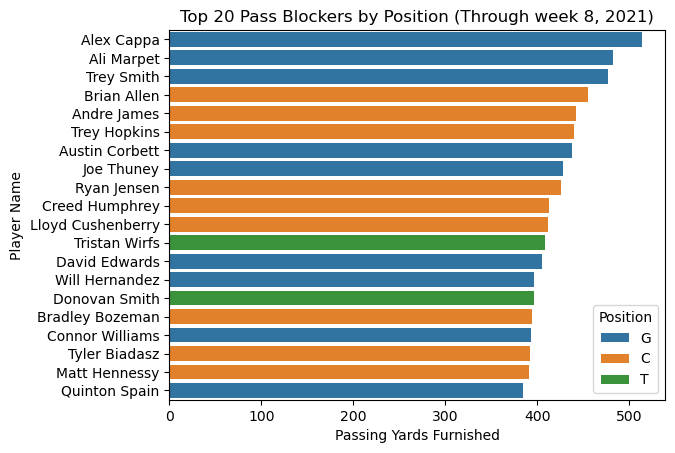

In [252]:
ax = sns.barplot(data=plot_table.nlargest(20, 'Passing_Yards_Furnished'),
            y='displayName',
            x='Passing_Yards_Furnished',
            hue='officialPosition',
           dodge = False)
sns.move_legend(ax, title='Position', loc='best')
_ = ax.set(xlabel='Passing Yards Furnished', ylabel = 'Player Name', title = 'Top 20 Pass Blockers by Position (Through week 8, 2021)')


In [ ]:
# Seaborn Objects not available in Kaggle
#p = so.Plot(plot_table.nlargest(20, 'Passing_Yards_Furnished'), y='displayName', x='Passing_Yards_Furnished', color='officialPosition').add(so.Bars())

#p.label(x='Passing Yards Furnished', y = 'Player Name', color = 'Position', title = 'Top 20 Pass Blockers by Position (Through week 8, 2021)')